___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://www.retailtouchpoints.com/wp-content/uploads/2020/09/Walmart-Redesign-exterior.jpg" width="300px" height="180px" />


# <font color= #bbc28d> **Stock Exchange Forecasting** </font>
#### <font color= #2E9AFE> `Lab 3 - Machine Learning`</font>
- <Strong> Sofía Maldonado, Diana Valdivia, Samantha Sánchez, Isabel Valladolid & Vivienne Toledo </Strong>
- <Strong> Fecha </Strong>: 20/11/2025.

___

<p style="text-align:right;"> Image retrieved from: https://www.retailtouchpoints.com/wp-content/uploads/2020/09/Walmart-Redesign-exterior.jpg</p>

# <font color= #bbc28d> **Introduction** </font>

Stock forecasting is one of the most important fields in finance, since **accurate predictions allow for better and more precise decision-making capabilites where investments are involved**. In this sense, data science integration via time series analysis and modeling are essential.

Intending to make use of some popular neural network models and their relevance to finance, this notebook covers the use of **Recurrent Neural Networks (RNN's) for stock exchange forecasting**, focusing on Walmart's stocks over the past 5 years. 

Two baseline models (SMA and ARIMA) will be compared to two RNN's models (RNN and LSTM) to evaluate performance and prediction power. The objective is to identify the best approach and manner to carry out predictions in the field of stock forecasting.

----

In [21]:
# === IMPORTS ===

# Generales
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# Redes Neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import alexnet, AlexNet_Weights, vgg16, VGG16_Weights
from torchvision import transforms
from torch.nn.init import kaiming_uniform_, xavier_uniform_, orthogonal_, zeros_

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Time Series Analysis
import mplfinance as mpf
from statsmodels.tsa.seasonal import seasonal_decompose

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# <font color= #bbc28d> **Data Loading** </font>

Using the library _yfinance_, the stocks of Walmart in the last five years were downloaded on 14/nov/2025. Open, High, Low, Close and Volume (OHLCV) fields were selected for the download, which will be the features used for model training and evaluation.

In [2]:
# # RUN THIS CODE ONLY ONE TIME
# start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')          # Gets last 5 years of data
# end_date = datetime.now().strftime('%Y-%m-%d')

# # Download Walmart prices
# wmt = yf.download('WMT', start=start_date, end=end_date, progress=True)

# # Flatten columns to get only data
# wmt.columns = wmt.columns.get_level_values(0)

# # Keep OHLCV data
# wmt = wmt[['Open', 'High', 'Low', 'Close', 'Volume']]

# # Save to csv
# wmt.to_csv('data/walmart_stocks.csv', index=True)

In [3]:
# Read data
df = pd.read_csv('data/walmart_stocks.csv')
df['Date'] = pd.to_datetime(df['Date'])             # Convert Date column to date type
df = df.set_index('Date')                           # Make the Date column the index
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-16,46.804732,47.697108,46.416065,47.398613,34560300
2020-11-17,46.795404,47.647361,46.384971,46.444050,42711600
2020-11-18,46.596410,47.159198,46.344554,46.356991,24936900
2020-11-19,46.472042,47.401731,46.428512,47.299126,18590700
2020-11-20,47.003731,47.498113,46.580864,46.714565,21937200


# <font color= #bbc28d> **Data Visualization** </font>

For starters, let's take a quick look at the data: 

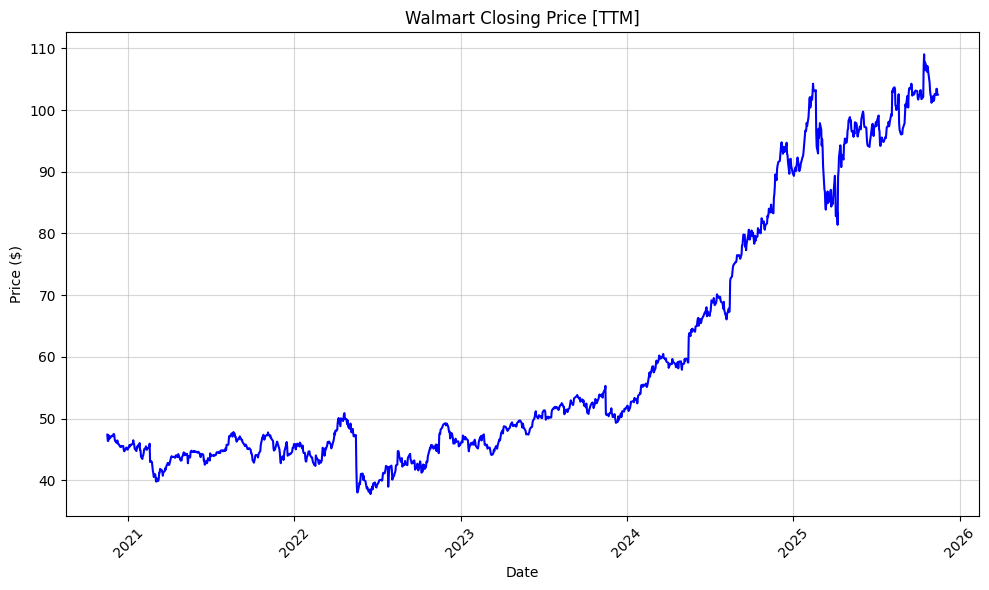

In [4]:
# Initialize an empty figure
plt.figure(figsize=(10, 6))
plt.grid(alpha=0.5)

# Plot the closing prices
plt.plot(
    df.index,
    df["Close"],
    color="blue",
    linewidth=1.5
)

# Set the plot title and axis labels
plt.title(f"Walmart Closing Price [TTM]")
plt.xlabel("Date")
plt.ylabel("Price ($)")

# Finish constructing the plot
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

As observed in the chart, Walmart's stock had been quite stable until around 2023, experiencing a sharp increase the following years.

<br>

Let's take a closer look at Walmart's stock behaviour via OHLCV data analysis with candlesticks charts, which showcase the relationship between OHLCV prices:

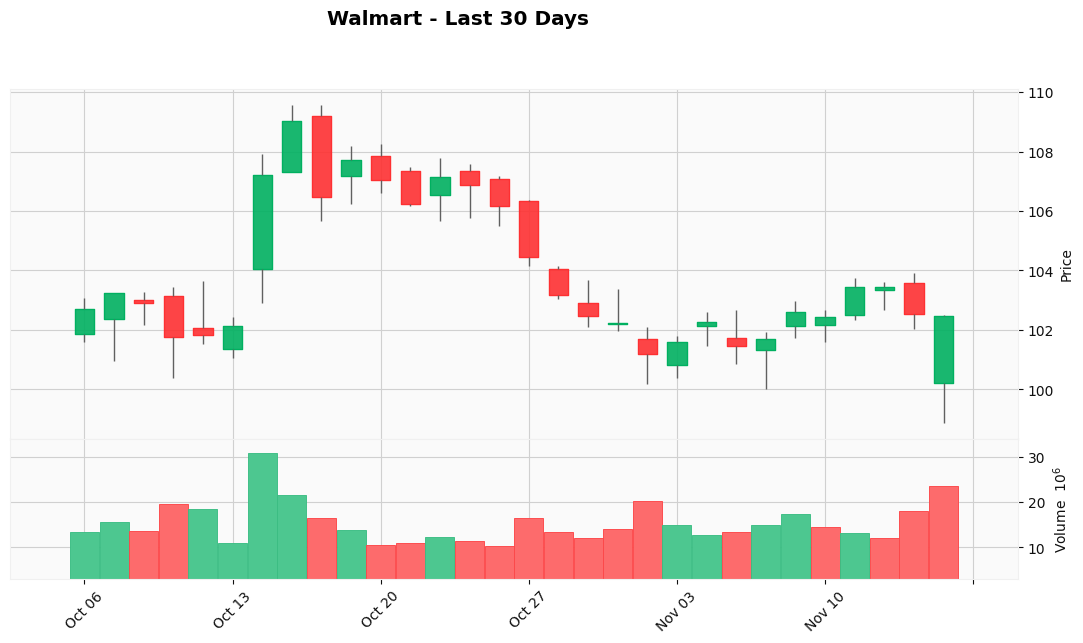

In [5]:
# Select last 30 days of data 
df_latest = df.tail(30)

# plot the latest data, thereby creating a "zoomed in" version of the plot
mpf.plot(
    df_latest,
    type="candle",
    style="yahoo",
    figsize=(14, 7),
    volume=True,
    title=f"Walmart - Last 30 Days"
)

In the last 30 days, Walmart's stock has been experiencing quite a decrease in value, with varying prices. Mostly of which result in worse closing prices at the end of the day.

# <font color= #bbc28d> **Preprocessing** </font>

Although there doesn't seem to be any missing data from the visualizations provided, let's further evaluate if the data contains any NaN values:

In [6]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Since there are no NaN values, the data is good to go through further preprocessing techniques. Firstly, let's apply a train-test-split to avoid data leakage:

In [7]:
# Establish test size
train_size = 0.8
split_index = int(len(df) * train_size)

# Train-Test-Split
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print(f"Train Size: {len(train_df)}")
print(f"Train Dates: {train_df.index.min()} to {train_df.index.max()} \n")
print(f"Test Size: {len(test_df)}")
print(f"Test Dates: {test_df.index.min()} to {test_df.index.max()}")

Train Size: 1004
Train Dates: 2020-11-16 00:00:00 to 2024-11-12 00:00:00 

Test Size: 252
Test Dates: 2024-11-13 00:00:00 to 2025-11-14 00:00:00


After applying a train-test-split, scaling the data is recommended, due to the high variance across time. And since data is derived from a time series, the best option is using a MinMaxScaler:

In [8]:
scaler = MinMaxScaler()

# Scale training data
train_df_scaled = scaler.fit_transform(train_df[['Close']])           # Keep only closing values
train_df_scaled = pd.Series(train_df_scaled.flatten(), index=train_df.index)

# Scale testing data
test_df_scaled = scaler.transform(test_df[['Close']])          
test_df_scaled = pd.Series(test_df_scaled.flatten(), index=test_df.index)

- **[PENDIENTE]** Deberíamos tmb checar atípicos pero no entendí series de tiempo alch
- **[PENDIENTE]** También valdría la pena aplicar transformaciones a la serie pero no entendí series de tiempo alch x2

### ehhh,, dunno what about this

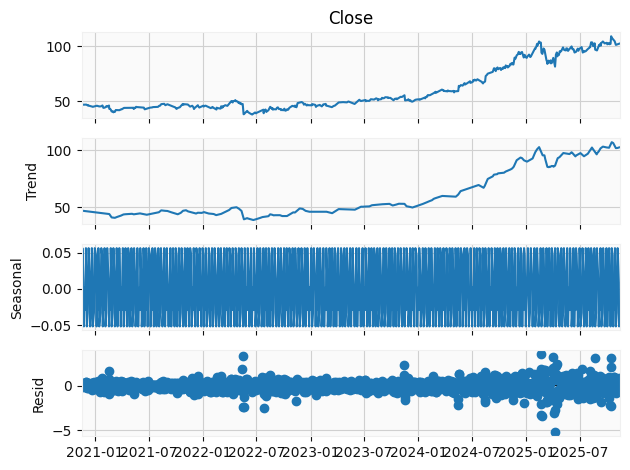

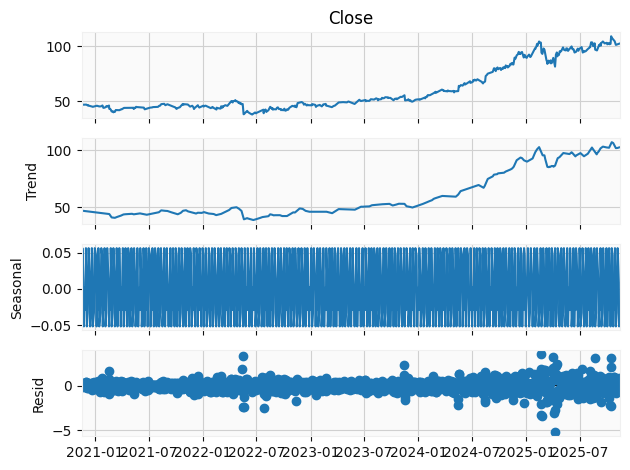

In [9]:
series_decompose = seasonal_decompose(df['Close'], model='additive', period=7)
series_decompose.plot()

# <font color= #bbc28d> **Baseline** </font>

The baseline models selected to be compared against RNN architectures are _**Moving Average**_ and _**ARIMA**_. The results of these models will be compared to the RNN architectures proposed later in this notebook.

## <font color= #66b0b0> &ensp; • **Simple Moving Average (SMA)** </font>

Simple Moving Average (SMA) is a model that **calculates the average of a set of data within a specified time frame, shifting with each new data** to provide a clearer view of the overall trend. It helps smooth out data fluctuations and reveals trends over time, however, it does not consider significant fluctuations in data, since all points are weighted equally. 

Due to the simplicity of the SMA model, no further preprocessing of data is needed besides the already applied MinMaxScaler.

In [17]:
# SMA model
def sma_forecast(train_df, test_df, window_size):
    history = list(train_df)                # Start with training values
    preds = []
    
    for i in test_df:
        # Calculate simple moving average
        if len(history) >= window_size:
            pred = np.mean(history[-window_size:])
        else:
            pred = np.mean(history)
        
        preds.append(pred)
        history.append(i)                   # Update with actual test value
    
    return np.array(preds)

Since SMA works with a window size, and as observed in the visualization, stock prices tend to vary quite a lot, a smaller window of 10 days will be used for predictions.

In [38]:
window_size = 10

# Run the model
preds_scaled = sma_forecast(train_df_scaled, test_df_scaled, window_size)

# Re-scale the predictions, since they're in the MinMaxScale scale
preds_original = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()

results = pd.DataFrame({
    'Actual': test_df['Close'].values,
    'SMA_Predicted': preds_original}, 
    index=test_df.index)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(results['Actual'], results['SMA_Predicted']))
mae = mean_absolute_error(results['Actual'], results['SMA_Predicted'])
mape = mean_absolute_percentage_error(results['Actual'], results['SMA_Predicted'])

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape *100:.2f}%')

RMSE: 2.8835
MAE: 2.2514
MAPE: 2.36%


After re-scaling the data for metric evaluation, it's clear that the fitted model performed quite good. It should be noted, however, that the precision of the model is in no short part because of the small window selected.

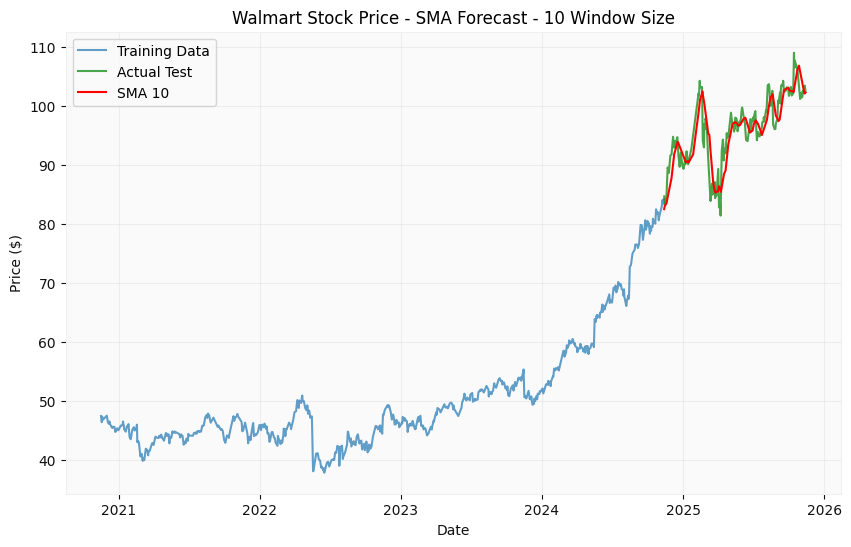

In [39]:
plt.figure(figsize=(10, 6))

plt.plot(train_df.index, train_df['Close'], label='Training Data', alpha=0.7)
plt.plot(test_df.index, test_df['Close'], label='Actual Test', alpha=0.7, color='green')
plt.plot(results.index, results['SMA_Predicted'], label=f'SMA {window_size}', color='red')

plt.title(f"Walmart Stock Price - SMA Forecast - {window_size} Window Size")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## <font color= #66b0b0> &ensp; • **ARIMA** </font> 

# <font color= #bbc28d> **Modeling** </font>

## <font color= #66b0b0> &ensp; • **Vanilla RNN (abierto a cambio)** </font>

## <font color= #66b0b0> &ensp; • **LSTM** </font>

# <font color= #bbc28d> **Bibliography** </font>

- https://pythonfintech.com/articles/plotting-stock-charts-ohlc-matplotlib-mplfinance